# To identify the tunnel congestion, first we analyse how the relationship between the traffic volume and the rush hours¶

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sys
import os
import warnings
import requests
import re
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore")

# Add the path # ADD TO README
sys.path.append('/Users/parvathyanilkumar/WorkSpace/Visual basic github/TunnelTrafficCongestion/')  # Replace with the correct path
from src.util.helper_functions import read_data,preprocess,save_to_csv,callAPI,determine_part_of_day,get_coordinates
#print("Current sys.path:", sys.path)

In [17]:
def configset(configPath,folderName,tunnelName):
    # Load the configuration
    with open("/Users/parvathyanilkumar/WorkSpace/Visual basic github/TunnelTrafficCongestion/config.json", "r") as f:
        config = json.load(f)

    # Access the file paths
    data_raw_path = config["data_raw_path"]+folderName
    data_processed_path = config["data_processed_path"]
    analysis_path = config["analysis_path"]
    os.makedirs(analysis_path+tunnelName,exist_ok=True) #create a folder with the tunnel name for saving all the plots    
    #tunnel_name = config["tunnel_name"]
    return data_raw_path,data_processed_path,analysis_path




In [3]:
def splitdfonlanes(df):
    #Filter out the dataframe based on the lane Lane 1 and Lane 2 are lanes thats in opposite direction
    felt_1_3_data=df[(df['Felt'] == 1) | (df['Felt'] == 3)]
    felt_2_4_data = df[(df['Felt'] == 2) | (df['Felt'] == 4)].copy()
    return felt_1_3_data,felt_2_4_data

### Data cleanup

In [4]:
new_missing_values = felt_1_3_data.isnull().sum()
    # Check data types to confirm conversions
data_types = felt_1_3_data.dtypes
data_types, new_missing_values



NameError: name 'felt_1_3_data' is not defined

In [5]:
#On converstion of the Gjennomsnittshastighet to numeric, there are 28 more missing daatas. 
#Since the dataset is huge and number of missing values are less in order to maintain data integrity as much as possible
#Filling in the missing values in the Gjennomsnittshastighet column with the median value of that column. The median is often as data might have outliers that could skew the mean
def fillMissingValues(df):
    #Check missing values
    new_missing_values = df.isnull().sum()
    # Check data types to confirm conversions
    print("Before filling missing values:",new_missing_values)
    df['Gjennomsnittshastighet'].fillna(df['Gjennomsnittshastighet'].median(), inplace=True)
    # Verify there are no longer any missing values in 'Gjennomsnittshastighet'
    final_missing_values = df['Gjennomsnittshastighet'].isnull().sum()
    df['Trafikkmengde'] = df['Trafikkmengde'].interpolate(method='linear')
    print("After filling missing values:",final_missing_values)
    #Set Fra as index aswell
    df.set_index('Fra', inplace=True)
    return df


### Exploratory Data Analysis
#### Trend Analysis : Visualize overall traffic volume over the time


In [6]:
def showTotalDailyTraffic(df,laneNumber,filepath):
    daily_traffic_volume = df['Trafikkmengde'].resample('D').sum()

    fig = plt.figure(figsize=(15, 6))
    daily_traffic_volume.plot(title='Daily Traffic Volume Trend in Lane '+str(laneNumber))

    plt.ylabel('Total Daily Traffic Volume for ')
    plt.grid(True)
    
    plt.savefig(filepath+'/daily_traffic_lane_{}.png'.format(laneNumber))
    plt.show()
   



In [7]:
showTotalDailyTraffic(felt_1_3_data,1) #Show daily traffic trend in lane 1 or 3


NameError: name 'felt_1_3_data' is not defined

In [8]:
showTotalDailyTraffic(felt_2_4_data,2) #Show daily traffic trend in lane 2 or 4

NameError: name 'felt_2_4_data' is not defined

In [9]:

#felt_2_4_data['Trafikkmengde'] = felt_2_4_data['Trafikkmengde'].interpolate(method='linear')

# Checking if there are any missing values left in Trafikkmengde after interpolation
#missing_after_imputation = felt_2_4_data['Trafikkmengde'].isnull().sum()

#missing_after_imputation

In [10]:

# Seasonal trend
#Hourly traffic volume - Avergae hourly traffic volume is shown
#Weekly traffic volume + Traffic pattern across different days of the week.
def seasonal_trend(df,felt,filepath):
    hourly_avg = df['Trafikkmengde'].groupby(df.index.hour).mean()
    weekly_avg = df['Trafikkmengde'].groupby(df.index.dayofweek).mean()
    
    #february_data = df[df['Dato'].dt.month == 12]

    # Calculate the weekly average traffic volume for days in February
    #weekly_avg = february_data['Trafikkmengde'].groupby(february_data['Dag']).mean()
    weekly_avg = df['Trafikkmengde'].groupby(df['Dag']).mean()

    # Plotting the hourly and weekly averages
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    # Hourly traffic pattern
    hourly_avg.plot(ax=ax[0], title='Average Hourly Traffic Volume in Lane '+felt)
    ax[0].set_xlabel('Hour of Day')
    ax[0].set_ylabel('Average Traffic Volume')

    # Weekly traffic pattern
    weekly_avg.plot(ax=ax[1], title='Average Weekly Traffic Volume in Lane '+felt)
    ax[1].set_xlabel('Day of Week')
    ax[1].set_ylabel('Average Traffic Volume')
    tick_positions = range(len(weekly_avg))# positions where you want the labels
    labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Set the positions and labels for the x-ticks
    ax[1].xaxis.set_major_locator(plt.FixedLocator(tick_positions))
    ax[1].xaxis.set_major_formatter(plt.FixedFormatter(labels))

   
    ax[1].set_xticklabels(labels, rotation=45)
    plt.tight_layout()
    plt.savefig(filepath+'/AvgWeeklyraffic_Lane{}.png'.format(felt))
    plt.show()
    
    # Analysing Hourly traffic per day for a week on an avergae
    # Grouped data by day of the week and hour of the day to calculate the average traffic flow
    traffic_flow_per_hour_per_day = df['Trafikkmengde'].groupby([df.index.dayofweek, df.index.hour]).mean().unstack(level=0)

    # Plotting the results
    plt.figure(figsize=(15, 8))
    hour_reformat = [f"{hour}:00" for hour in range(24)]
    for day in range(7):
        plt.plot(traffic_flow_per_hour_per_day[day], label=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'][day])

    plt.title('Average Traffic Flow per Hour per Day of the Week for Lane '+felt)
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Traffic Volume')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(0, 24),hour_reformat)
    plt.savefig(filepath+'/WeeklyAvgTraffperHr_Lane{}.png'.format(felt))
    plt.show()
    
    # Extract hour from Fra datetime column for hourly aggregation
    df['Hour'] = df.index.hour

    # Group by the extracted hour to calculate mean traffic volume and average speed per hour
    hourly_aggregation = df.groupby('Hour').agg({'Trafikkmengde':'mean', 'Gjennomsnittshastighet':'mean'}).reset_index()

    # Plotting hourly trends for traffic volume and average speed
    fig, ax1 = plt.subplots(figsize=(14, 7))

    color = 'tab:blue'
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Average Traffic Volume', color=color)
    ax1.plot(hourly_aggregation['Hour'], hourly_aggregation['Trafikkmengde'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  
    color = 'tab:green'
    ax2.plot(hourly_aggregation['Hour'], hourly_aggregation['Gjennomsnittshastighet'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  #to prevent right handling in getting clipped
    plt.title('Hourly Trends in Traffic Volume and Average Speed for Lane '+felt)
    plt.savefig(filepath+'/SpeedTrafficTrend_Lane{}.png'.format(felt))
    plt.show()


In [19]:
def feature_engineering(df,tunnel_name):
    # Feature engineering steps
    # Timebased features
    # Here specific features like isWeekend - if weekeday or weekend to capture the traffic pattern
    # Part of the day- to identify the pattern at different time of the day
    # Seasonality - to see seasonal variations in the traffic
    
    df['DayOfWeek'] = df['Dato'].dt.dayofweek
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
    df['DayNumber'] = df["Til"].dt.day
    df['Hour'] = df["Til"].dt.hour
    df['DayOfMonth'] = df["Til"].dt.month
    
    coordinates =get_coordinates(tunnel_name)
    def categorize_part_of_day(row):
        tunnel_name = row["Navn"]
        #date = row["Dato"]
        datetime_str = pd.to_datetime(row["Dato"]).date()
       
        # Get twilight times using the API call
        morning, night = callAPI(tunnel_name, datetime_str,coordinates)
        
        # Clean the morning and night times
        morning_cleaned = morning.split()[0]  # Get valid time
        morning_cleaned = re.sub(r'[^\d:]', '', morning_cleaned)  # Remove unwanted characters
    
        night_cleaned = night.split()[0]  # Get valid time
        night_cleaned = re.sub(r'[^\d:]', '', night_cleaned) 
  
        return determine_part_of_day(row["Fra tidspunkt"], morning_cleaned, night_cleaned)
    july_data = df[df['Måned'] == 'Januar'] 
    july_data.head()
    #df['PartOfDay'] = july_data.apply(categorize_part_of_day, axis=1)

    def month_to_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'

    df['Season'] = df['DayOfMonth'].apply(month_to_season)
    # Seasonal Trend Visualization
    quartiles = df.groupby('Season')['Trafikkmengde'].quantile([0.25, 0.5, 0.75]).unstack()
    quartiles.columns = ['Q1', 'Q2', 'Q3']

    # Plotting the box plot with quartile annotations
    plt.figure(figsize=(12, 6))
    boxplot = sns.boxplot(x='Season', y='Trafikkmengde', data=df)

    # Title and labels
    plt.title('Seasonal Trends in Traffic Volume with Quartile Annotations')
    plt.xlabel('Season')
    plt.ylabel('Traffic Volume')

    # Annotating the quartiles
    for i, season in enumerate(df['Season'].unique()):
        y_q1 = quartiles.loc[season, 'Q1']
        y_q2 = quartiles.loc[season, 'Q2']
        y_q3 = quartiles.loc[season, 'Q3']
    
        # Adjusting the position for annotations to avoid overlapping
        x_offset = i
        plt.text(x_offset, y_q1, f'Q1: {y_q1:.2f}', ha='center', va='bottom', color='blue')
        plt.text(x_offset, y_q2, f'Q2: {y_q2:.2f}', ha='center', va='bottom', color='yellow')
        plt.text(x_offset, y_q3, f'Q3: {y_q3:.2f}', ha='center', va='bottom', color='red')

    plt.xticks(rotation=45)  
    plt.show()



    return df

################################

#from geopy.geocoders import Nominatim

#def get_coordinates(location_name):
#    geolocator = Nominatim(user_agent="my_geocoder")
 #   location = geolocator.geocode(location_name)
    
  #  if location:
   #     return location.latitude, location.longitude
    #else:
     #   return None

# for Gudvangatunnelen
location_name = "Gudvangatunnelen"
#coordinates = get_coordinates(location_name)

#if coordinates:
 #   print(f"Coordinates for {location_name}: Latitude {coordinates[0]}, Longitude {coordinates[1]}")
#else:
  #  print(f"Coordinates for {location_name} not found.")
############################################################

def aggregate_traffic_data(df, freq):
    # Aggregate the traffic volume data to daily, weekly, and monthly
    if freq == 'D':
        daily_traffic = df.resample('D')['Trafikkmengde'].sum().reset_index()
        daily_traffic.set_index('Dato', inplace=True)
        daily_traffic.to_csv('daily_traffic.csv', index=False)
        print("Daily Traffic Data Saved")
    elif freq == 'W':
        weekly_traffic = df.resample('W')['Trafikkmengde'].sum().reset_index()
        weekly_traffic.to_csv('weekly_traffic.csv', index=False)
        print("Weekly Traffic Data Saved")
    elif freq == 'M':
        monthly_traffic = df.resample('M')['Trafikkmengde'].sum().reset_index()
        monthly_traffic.to_csv('monthly_traffic.csv', index=False)
        print("Monthly Traffic Data Saved")
    else:
        print("Invalid frequency. Choose 'D', 'W', or 'M'.")



def trend_analysis_line_plot(df):
    # Trend analysis line plot
    print(df.head())
    first_week_march = df['2021-03-01':'2021-03-07'].copy()
    first_week_march['hour'] = first_week_march['Til'].dt.hour

    weekly_traffic = first_week_march.pivot_table(index='hour', columns='Dag', values='Trafikkmengde', aggfunc='mean')

    plt.figure(figsize=(12, 7))
    for day in weekly_traffic.columns:
        plt.plot(weekly_traffic.index, weekly_traffic[day], label=day)

    plt.title('Average Hourly Traffic Volume for the First Week of March 2021')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Traffic Volume')
    plt.xticks(weekly_traffic.index)
    plt.legend(title='Day of the Week')
    plt.grid(True)
    plt.show()



Before filling missing values: Trafikkregistreringspunkt       0
Vegreferanse                    0
Navn                            0
Felt                            0
Fra                             0
Til                             0
Dato                            0
Dag                             0
Måned                           0
Fra tidspunkt                   0
Til tidspunkt                   0
Trafikkmengde                1623
Gyldige passeringer          1623
Dekningsgrad                 1623
Gjennomsnittshastighet       5012
85-fraktil                   5012
dtype: int64
After filling missing values: 0


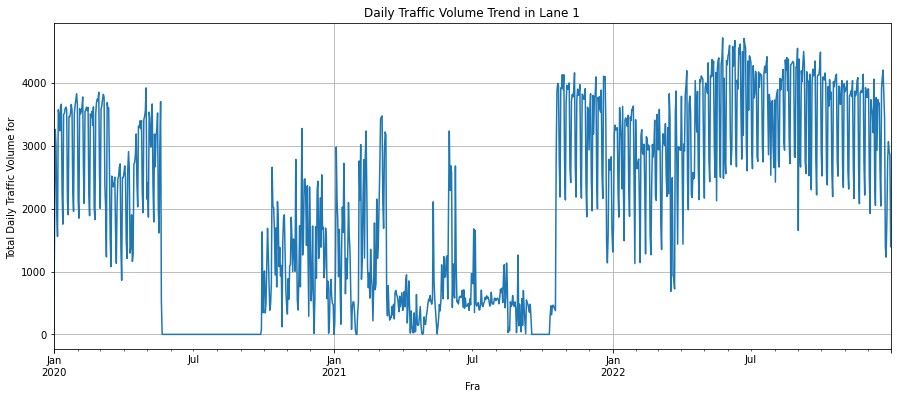

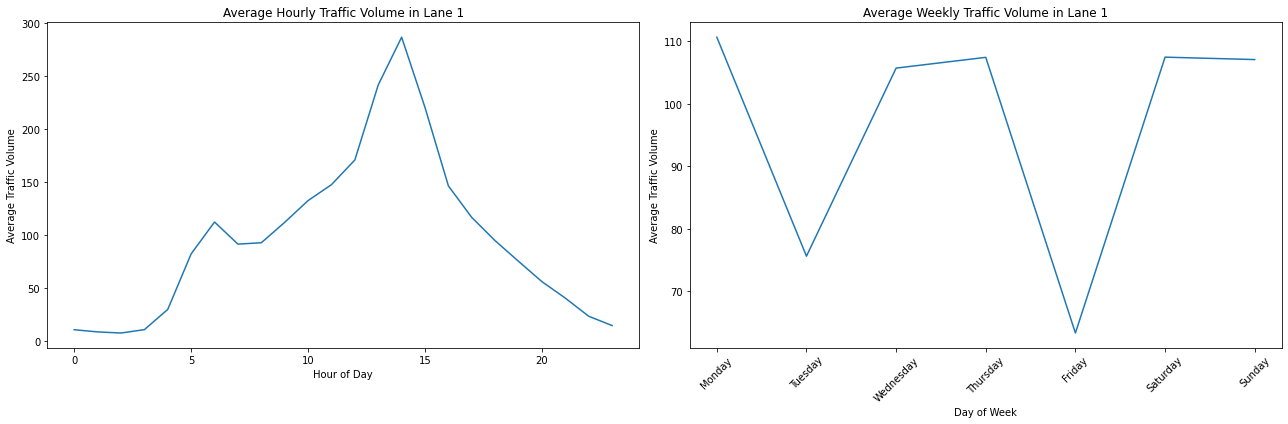

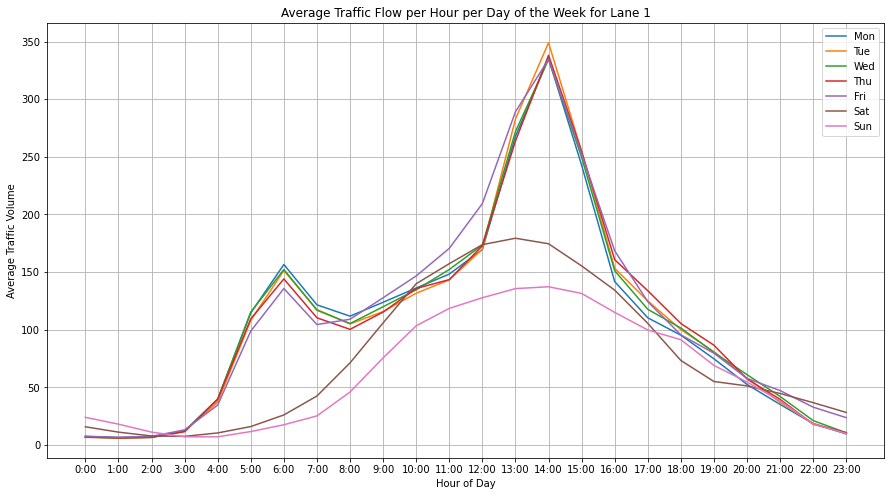

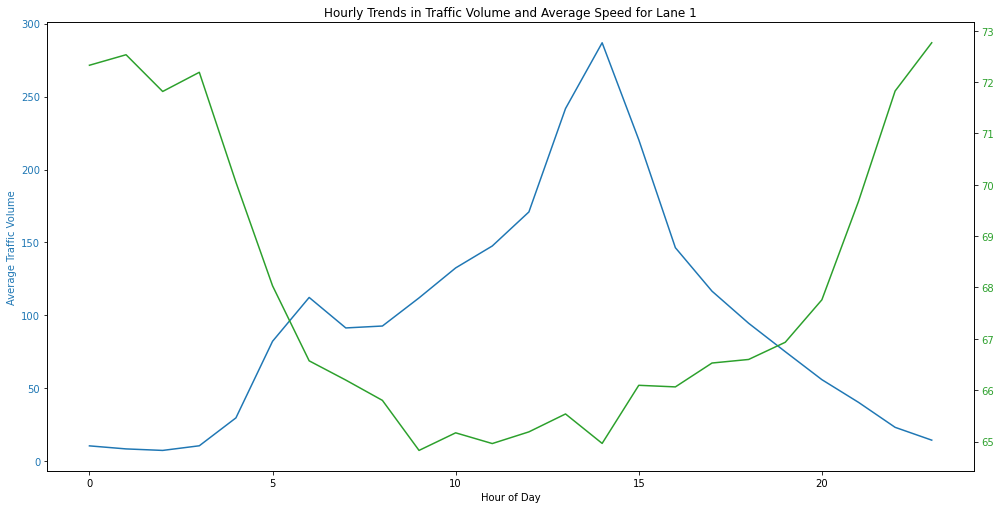

Coordinates for TUSSENTUNNELEN: Latitude 62.780231, Longitude 7.249453


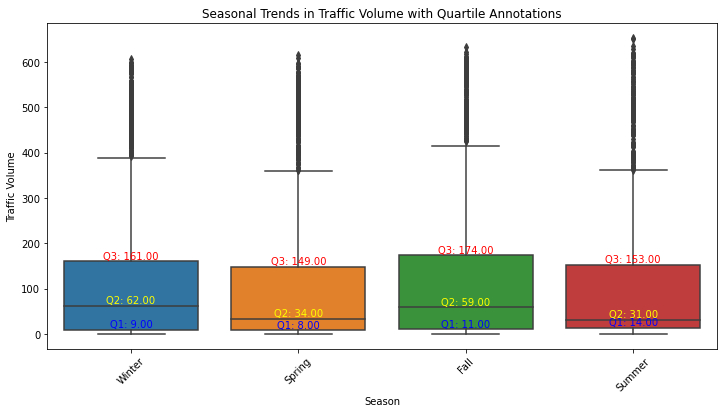

Before filling missing values: Trafikkregistreringspunkt       0
Vegreferanse                    0
Navn                            0
Felt                            0
Fra                             0
Til                             0
Dato                            0
Dag                             0
Måned                           0
Fra tidspunkt                   0
Til tidspunkt                   0
Trafikkmengde                5543
Gyldige passeringer          5543
Dekningsgrad                 5543
Gjennomsnittshastighet       9401
85-fraktil                   9401
dtype: int64
After filling missing values: 0


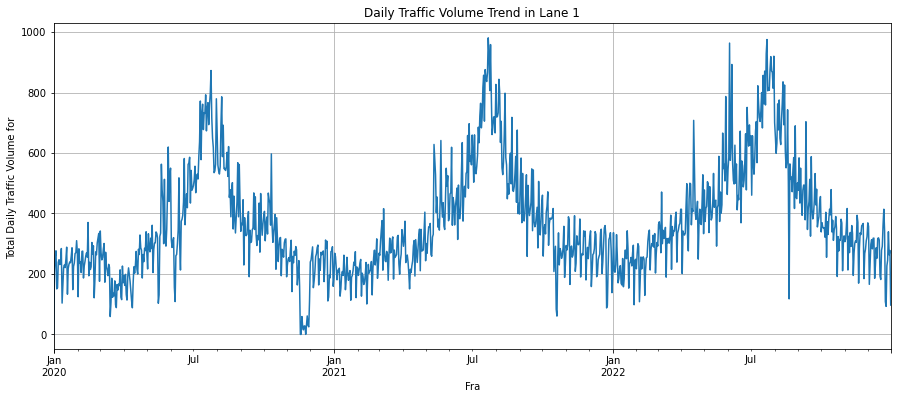

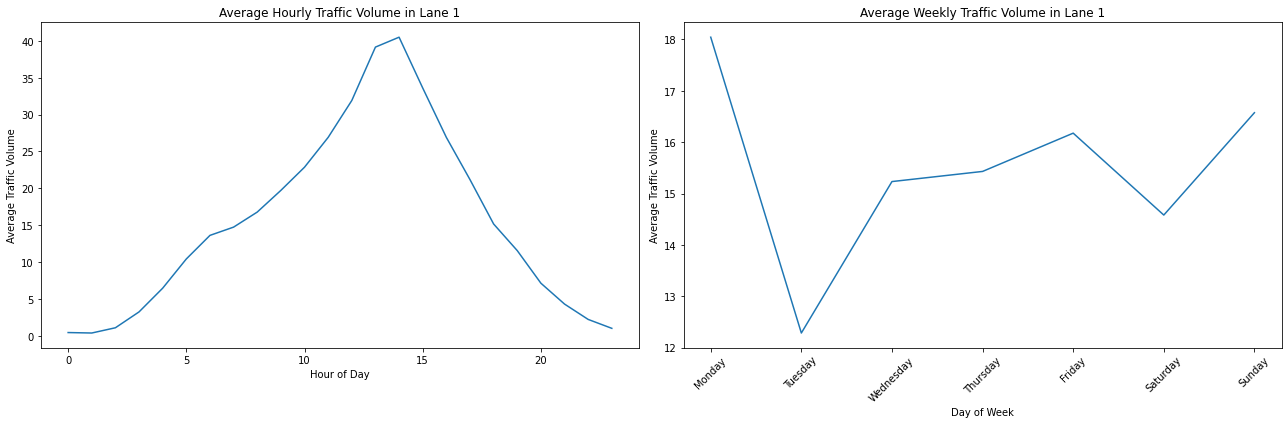

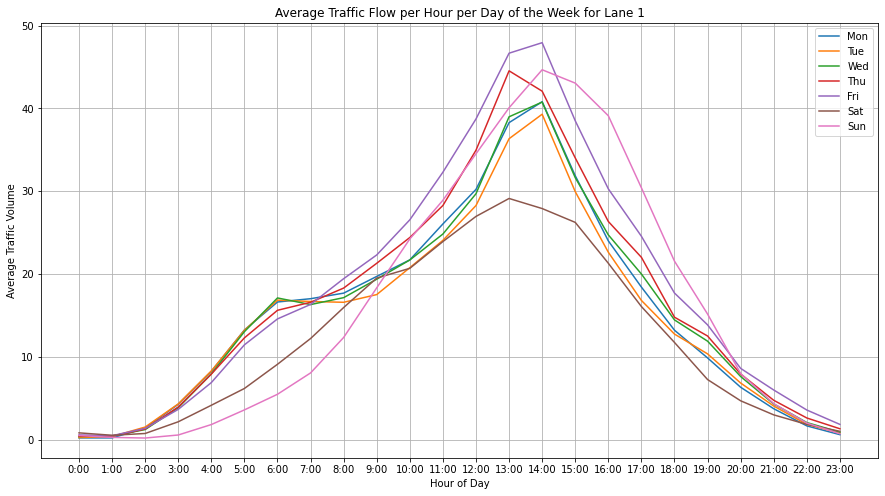

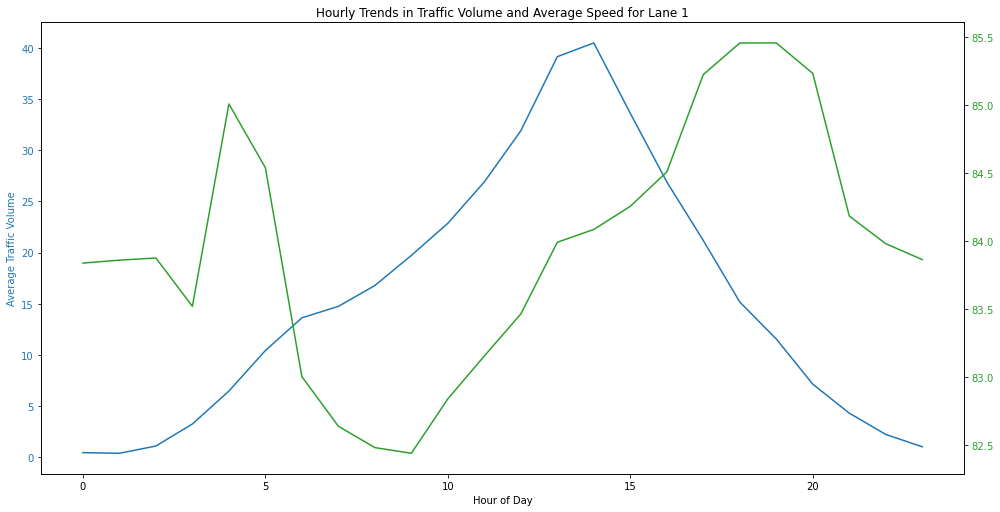

Coordinates for Jondalstunnelen: Latitude 60.1988617, Longitude 6.2568701


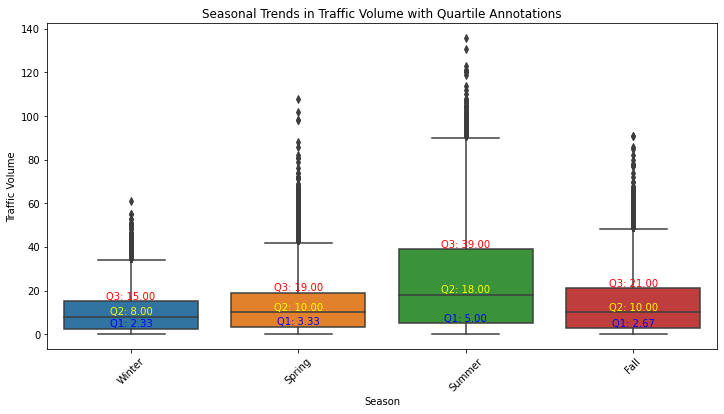

Before filling missing values: Trafikkregistreringspunkt       0
Vegreferanse                    0
Navn                            0
Felt                            0
Fra                             0
Til                             0
Dato                            0
Dag                             0
Måned                           0
Fra tidspunkt                   0
Til tidspunkt                   0
Trafikkmengde                   0
Gyldige passeringer             0
Dekningsgrad                    0
Gjennomsnittshastighet       4330
85-fraktil                   4330
dtype: int64
After filling missing values: 0


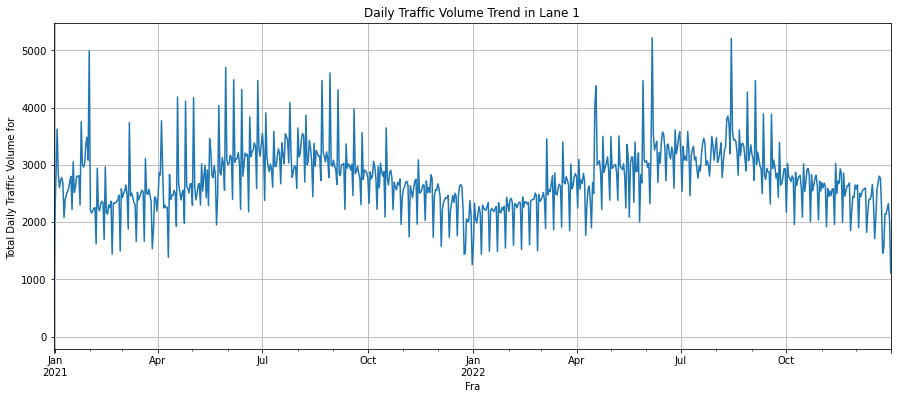

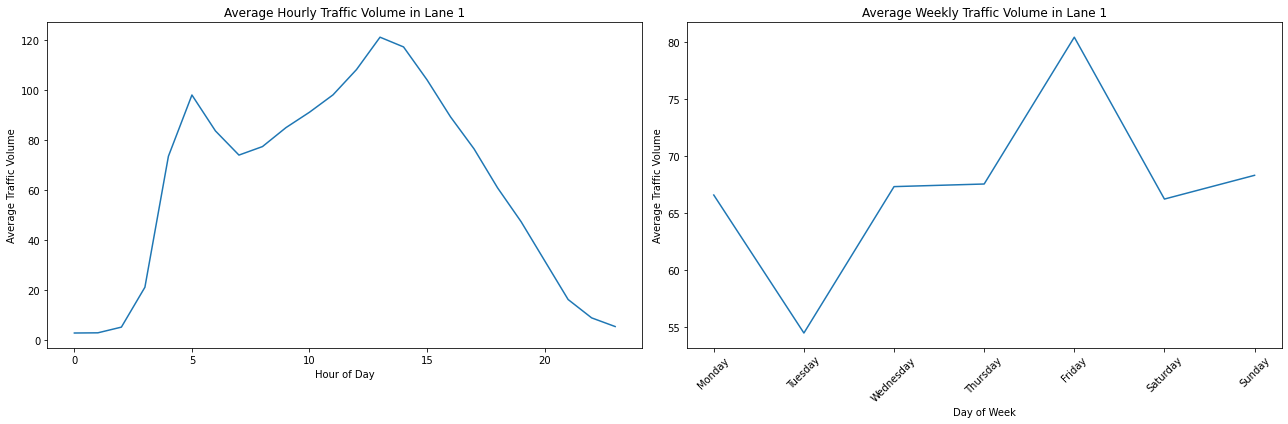

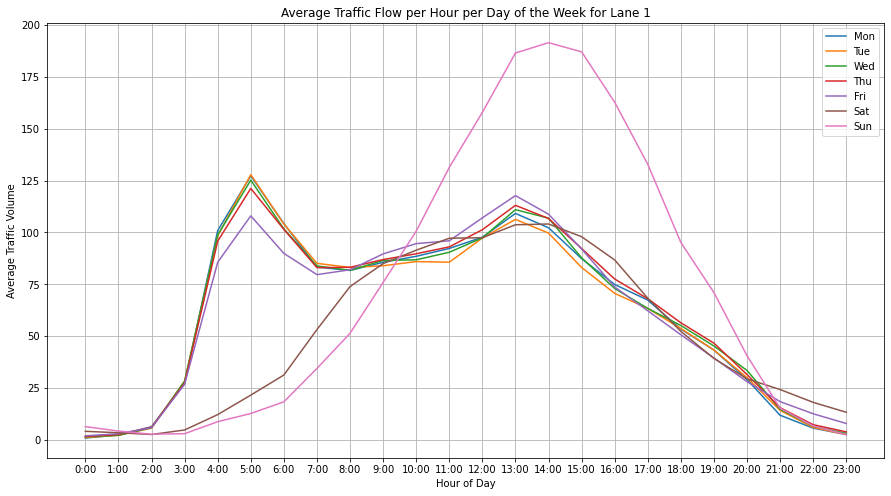

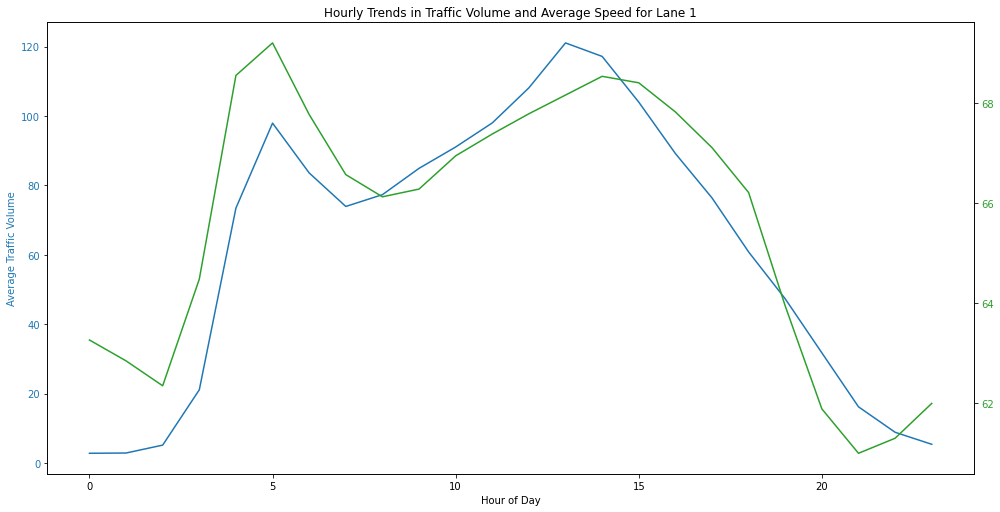

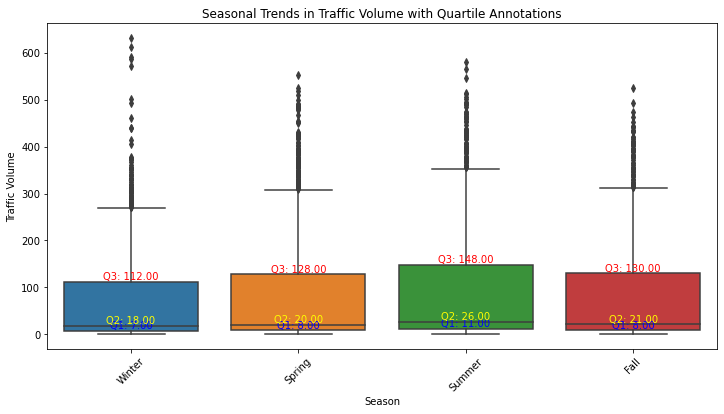

In [21]:
def analyse_for_multiple_tunnels(tunnel_files,lane):
    for tunnel_name, file_path in tunnel_files.items():
        data_raw_path,data_processed_path,analysis_path=configset("/Users/parvathyanilkumar/WorkSpace/Visual basic github/TunnelTrafficCongestion/config.json",file_path,tunnel_name)
        data = read_data(data_raw_path)
        df_felt1_3,df_felt_2_4=splitdfonlanes(data)
       
        if(lane ==1 or lane == 3):
            data =  preprocess(df_felt1_3)
        else:
            data = preprocess(df_felt2_4)
       
        data = fillMissingValues(data)
        
        showTotalDailyTraffic(data,1,analysis_path+tunnel_name) 
        seasonal_trend(data,"1",analysis_path+tunnel_name)  
       
        data = feature_engineering(data,tunnel_name)
        save_to_csv(data,data_processed_path + tunnel_name + '_preprocessed.csv')
        

if __name__ == "__main__":
   

     # multiple tunnels
    tunnel_files = {
       # 'FANNEFJORDTUNNELEN': 'FANNEFJORDTUNNELEN timesdata 2020-2022.xlsx',
        #'GUDVANGATUNNELEN': 'GUDVANGATUNNELEN 2022.xlsx',
        #'Ilsviktunnelen': 'ILSVIKA timesverdier 2020-2022.xlsx',
        'TUSSENTUNNELEN': 'TUSSENTUNNELEN timesdata 2020-2022.xlsx',
        'Jondalstunnelen': 'Jondalstunnelen timesdata 2020-2022.xlsx',
        'RYFYLKETUNNELEN MOT STAVANGER': 'RYFYLKETUNNELEN MOT STAVANGER timesdata 2020-2022.xlsx',
        
        
    } 
        
   # for value in tunnel_files.values():
    analyse_for_multiple_tunnels(tunnel_files,1)


